## Proj_01 : Image Classification
- Source : UdaCity, Machine Learning Intro, Deep Learning

## Introduction
In this project, I will train an image classifier to recognize different species of flowers.<br>
I'll be using [this dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories. 
The dataset can be downloaded from [here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz) directly.<br>
I show some examples below.

<img src='Data/Proj_01/asset/Flowers.png' width=500px>

## Goal
The goal of this project is 

<a id="mokuji_0"></a>
## Contents
1. <a href="#mokuji_1">Exploring the Dataset</a><br>
  1-1. [Overview the data](#mokuji_1_1)<br>
  1-2. [Check invalid and missing data](#mokuji_1_2)<br>
  1-3. [Data exploration : income](#mokuji_1_3)<br>
  1-4. [Data exploration : numerical data](#mokuji_1_4)<br>
  1-5. [Data exploration : string data](#mokuji_1_5)<br>
  <br>
2. [Preprocessing the Dataset](#mokuji_2)<br>
  2-1. [Transformation : skewed continuous data](#mokuji_2_1)<br>
  2-2. [Normalization : numerical data](#mokuji_2_2)<br>
  2-3. [Normalization : non-numerical data](#mokuji_2_3)<br>
  2-4. [Shuffle and Split Data](#mokuji_2_4)<br>
  <br>
3. [Modeling](#mokuji_3)<br>
  3-1. [Metrics](#mokuji_3_1)<br>
  3-2. [Recap of Metrics](#mokuji_3_2)<br>
  3-3. [Naive Predictor Performace](#mokuji_3_3)<br>
  3-4. [Select Supervised Learning Models](#mokuji_3_4)<br>
  3-5. [Create a training and predicting pipeline](#mokuji_3_5)<br>
  3-6. [Initial Model Evaluation](#mokuji_3_6)<br>
  3-7. [Chose the Best Model](#mokuji_3_7)<br>
  3-8. [Model Tuning](#mokuji_3_8)<br>
  <br>
4. [Evaluation](#mokuji_4)<br>
  4-1. [Final Model Evaluation](#mokuji_4_1)<br>
  4-2. [Feature Importance](#mokuji_4_2)<br>
  
[ddd](https://github.com/paulstancliffe/Udacity-Image-Classifier/blob/master/Image%20Classifier%20Project.ipynb)

In [1]:
# Import Libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
#
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#
from PIL import Image
import numpy as np
import pandas as pd
from pandas import Series
import json

<a id="mokuji_1"></a>
## <a href="#mokuji_0">1. Load the Dataset</a>

The dataset is split into three parts, training, validation, and testing.<br>
For the training, I'll apply transformations such as random scaling. cropping, and flipping. This will help the network generalize leading to better performance.
- The input datasize is needed to be resized to 224 x 224 pixels as required by the pore-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For these sets, there is no need to perform any scaling or rotation transformations, but it is needed to resize and crop the images to the appropriate size.

For all three sets, I normalize the means and standard deviations of the images to what network expects.
For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and +1 instead of 0 and +1.

In [2]:
data_dir = "./Data/Proj_01"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir  = data_dir + "/test"

### Define `transforms` for the training, validation, and testing sets

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                     ])

### Load the datasets using `ImageFolder`

In [4]:
train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_datasets  = datasets.ImageFolder(test_dir,  transform=test_transforms)

### Define `dataloaders` using the image datasets and the transforms

In [5]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_datasets,  batch_size=64, shuffle=True)

### Label mapping
To map `category indices` to `the actual flower names`, I use `cat_to_name.json` which is a JSON file and I can read it with the [`json` module](https://docs.python.org/2/library/json.html)

In [6]:
with open('./Data/Proj_01/cat_to_name.json', 'r') as f:
    map_cat_to_name = json.load(f)

I show the contents of `map_cat_to_name`.

In [7]:
list_cat_to_name = list(map_cat_to_name.items())
print("------- Three map contens ------")
print(list_cat_to_name[:3])
print("------- Map Size ------")
print(len(list_cat_to_name))

------- Three map contens ------
[('21', 'fire lily'), ('3', 'canterbury bells'), ('45', 'bolero deep blue')]
------- Map Size ------
102


<a id="mokuji_2"></a>
## [2. Building and Training the classifier](#mokuji_0)


Now that the data is ready, so it's time to build and train the classifier. As usual, I use one of the pretrained models from `torchvision.models` to get the image features. BUild and train a new feed-forward classifer using those features.

I will do the followings:
  1. Load a pre-trained network.
  2. Define a new, untrained feed-forward network as a classifier, using `ReLU` activations and `Dropout`.
  3. Train the classifier layers using backpropagation using the pre-trained network to get the features.
  4. Track the loass and accuracy on the validation set to determine the best hyperparameters.

I select VGG16. In the [image below](https://pytorch.org/hub/pytorch_vision_vgg/), VGG16 is described in the column `D`.<br>
The classifier layers of VGG16 is the last 4 steps.
- FC-4096
- FC-4096
- FC-1000
- soft-max

When I perform the transfer learning, I modify the classifier layers to fit new dataset.

<img src="./Data/Proj_01/vgg.png"/>

I show the model structure of the orignal vgg16.

In [8]:
original_model = models.vgg16(pretrained=True)
original_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Build my network
I create a function to output the VGG16 model and optimizer. The dataset of this projects has 102 classes.<br>
So, I modify the classifier of VGG16 to be able to output 102 classes.

In [9]:
def createVGG16(dropout=0.2, learning_rate=0.001):
    # Create a VGG model
    model = models.vgg16(pretrained=True)
    
    # Freeze parameter update
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify last layers
    model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                     nn.ReLU(),
                                     nn.Dropout(dropout),
                                     nn.Linear(4096, 1000),
                                     nn.ReLU(),
                                     nn.Dropout(dropout),
                                     nn.Linear(1000, 102),
                                     nn.LogSoftmax(dim=1))
    
    # Create an instance of the optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr = learning_rate)
    
    return model, optimizer

I create my VGG16 model which has new classifier layers. In the cell below, I can see that the output size is modified to 102.

In [10]:
my_model, my_optimizer = createVGG16(dropout=0.2, learning_rate=0.001)
print(my_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

I use the [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) which is useful to train a classification problem with C classes.<br>

`torch.nn.NLLLoss(weight=None, size_average=None, ignore_index=- 100, reduce=None, reduction='mean')`

$$
    loss(x,y) = \sum_{n=1}^{N}(\frac{1}{\sum_{m=1}^{N}w_{y_m}})l_n\quad
$$

- x is the input
- y is the target
- w is the weight
- N is the batch size

I want to use SoftMax + CrossEntropyError, but I use LogSoftmax as a output function, so I use nnllloss which have no `log`.

[ref](https://tatsukawa.hatenablog.com/entry/2020/04/06/054700)

In [11]:
criterion = nn.NLLLoss()

Send the model to GPU

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)
my_model.to(device);

device =  cuda


### Train my network

#### explanations of variable in the cell below
- log_softmax.shape = [batch_size , class_size]
- 

In [13]:
epochs = 15
train_losses = []
valid_losses = []
accuracies   = []

for epoch in range(epochs):

    #---------------------------------------- Loop for training
    time_start = time.time()
    train_loss_sum = 0
    my_model.train() # GoTo Train Mode
    #
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # send data to gpu
        my_optimizer.zero_grad()              # initialize the gradients
        log_softmax = my_model(images)        # performe forward
        loss = criterion(log_softmax, labels) # calculate the loss = SoftMax + Cross Entropy Error
        loss.backward()                       # performe backpropagation and calculate the gradients
        my_optimizer.step()                   # update the weights and bias
        train_loss_sum += loss.item()             # accumulate the loss
    
    #---------------------------------------- Loop for validation
    my_model.eval() # Go To Evaluation Mode
    valid_loss_sum = 0
    accuracy_sum  = 0
    #
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device) # send data to gpu
        log_softmax = my_model(images) # output is Log(SoftMax)
        loss = criterion(log_softmax, labels)
        valid_loss_sum += loss.item()
        
        # Calculate Accuracy
        softmax = torch.exp(log_softmax) # Log(SoftMax) -> SoftMax
        
        # Get the class which have the largest probalibity
        # top_class size is the batch_size
        top_probability, top_class = softmax.topk(1, dim=1) 
        
        # Compare classes between prediction and ground trueth
        equals = (top_class == labels.view(*top_class.shape))
        accuracy_sum += torch.mean(equals.type(torch.FloatTensor))
        
    #---------------------------------------- Create Output Variables
    # Calc Train Time for each epoch
    time_end  = time.time()
    time_diff = time_end - time_start
    
    train_losses.append(train_loss_sum / len(train_loader))
    valid_losses.append(valid_loss_sum / len(valid_loader))
    accuracies.append(accuracy_sum / len(valid_loader))

    print("Epoch:{}/Time:{:.0f}/Train_Loss:{:.4f}/Valid_Loss:{:.4f}/Accuracy:{:.4f}"\
          .format(epoch+1, time_diff, train_losses[-1], valid_losses[-1], accuracies[-1]))

Epoch:1/Time:69/Train_Loss:3.1539/Valid_Loss:1.1810/Accuracy:0.6728
Epoch:2/Time:67/Train_Loss:1.4307/Valid_Loss:0.8106/Accuracy:0.7729
Epoch:3/Time:67/Train_Loss:1.0984/Valid_Loss:0.7365/Accuracy:0.8119
Epoch:4/Time:68/Train_Loss:0.9409/Valid_Loss:0.6242/Accuracy:0.8407
Epoch:5/Time:68/Train_Loss:0.8759/Valid_Loss:0.4717/Accuracy:0.8646
Epoch:6/Time:69/Train_Loss:0.8117/Valid_Loss:0.4618/Accuracy:0.8767
Epoch:7/Time:68/Train_Loss:0.7697/Valid_Loss:0.4224/Accuracy:0.8845
Epoch:8/Time:68/Train_Loss:0.7159/Valid_Loss:0.4173/Accuracy:0.8898
Epoch:9/Time:68/Train_Loss:0.7107/Valid_Loss:0.3793/Accuracy:0.8989
Epoch:10/Time:68/Train_Loss:0.6687/Valid_Loss:0.4072/Accuracy:0.9049
Epoch:11/Time:69/Train_Loss:0.6677/Valid_Loss:0.3886/Accuracy:0.9095
Epoch:12/Time:69/Train_Loss:0.6813/Valid_Loss:0.3886/Accuracy:0.9082
Epoch:13/Time:69/Train_Loss:0.6509/Valid_Loss:0.3942/Accuracy:0.9073
Epoch:14/Time:70/Train_Loss:0.6475/Valid_Loss:0.4278/Accuracy:0.9054
Epoch:15/Time:69/Train_Loss:0.6448/Valid_Lo

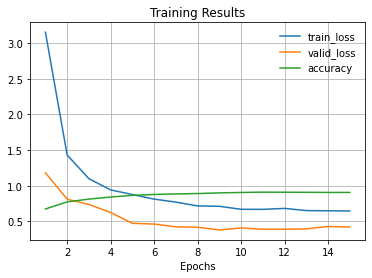

In [14]:
x_data = np.arange(len(train_losses)) + 1

plt.plot(x_data, train_losses, label='train_loss')
plt.plot(x_data, valid_losses, label='valid_loss')
plt.plot(x_data, accuracies,   label='accuracy')
plt.legend(frameon=False)
plt.xlabel("Epochs")
plt.title("Training Results")
plt.grid();

### Test my network

In [15]:
my_model.eval()
accuracies = []
time_start = time.time()

with torch.no_grad():
    #------------------------------------- Loop for each batch
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        log_softmax    = my_model(images)
        
        # Calculate Accuracy
        softmax = torch.exp(log_softmax) # Log(SoftMax) -> SoftMax
        
        # Get the class which have the largest probalibity
        # top_class size is the batch_size
        _ , top_class = softmax.topk(1, dim=1) 
        
        # Compare classes between prediction and ground trueth
        equals = (top_class == labels.view(*top_class.shape))
        accuracies.append( torch.mean(equals.type(torch.FloatTensor)) )

print("Calc Time for Test = {:.0f}".format(time.time()- time_start))

Calc Time for Test = 7


In [16]:
# Get average accuracy
accuracy_ave = 0

for acc in accuracies:
    accuracy_ave += acc

accuracy_ave /= len(accuracies)

print("Average Accuracy = {:.2f}".format(accuracy_ave))

Average Accuracy = 0.88


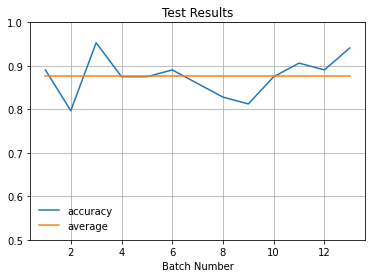

In [17]:
x_data   = np.arange(len(test_loader)) + 1
ave_data = np.ones((len(test_loader),1)) * float(accuracy_ave)

plt.plot(x_data, accuracies,   label='accuracy')
plt.plot(x_data, ave_data,     label='average')
plt.legend(frameon=False)
plt.xlabel("Batch Number")
plt.title("Test Results")
plt.ylim(0.5, 1.0)
plt.grid();

### Save the checkpoint

In [18]:
file_path_check_point = "./Data/Proj_01/vgg_flower_classification.pth"
torch.save({"epoch":epochs, 
            "model_state_dict":my_model.state_dict(), 
            "optimizer_state_dict":my_optimizer.state_dict(),
            "map_cat_to_name": map_cat_to_name},
            file_path_check_point)

### Load the checkpoint

In [19]:
def load_checkpoint(file_path_check_point):
    model, optimizer = createVGG16()
    check_point = torch.load(file_path_check_point)
    #
    model.load_state_dict(check_point["model_state_dict"])
    optimizer.load_state_dict(check_point["optimizer_state_dict"])
    epoch = check_point["epoch"]
    cat_to_name = check_point["map_cat_to_name"]
    return model, optimizer, epoch, cat_to_name

In [20]:
file_path_check_point = "./Data/Proj_01/vgg_flower_classification.pth"
model, optimizer, epoch, cat_to_name = load_checkpoint(file_path_check_point)

### Create a function `process_image` to process input images

1. Resize images whose shortest side is 256 pixels, keeping the aspect ratio
2. Crop out the center 224x224 portion of the image.
3. Modify value range of color channels to be 0.0 to 1.0.
4. Modify means and standard deviations because my network expects that 
`means = [0.485, 0.456, 0.406]` and `standard deviations = [0.229, 0.224, 0.225]`.
5. Modify the order of dimensions to `[Color, Widgh, Height]`.

In [21]:
def process_image(file_path_image):
    '''
    Resize, crop, and normalizes a PIL image for a PyTorch model.
    Returns an Numpy array
    '''
    size = [256,256]
    crop_size = 224
    
    # Read image as a PIL object
    im = Image.open(file_path_image, "r")
    
    # 1. Resize images whose shortest side is 256 pixels, keeping the aspect ratio
    if im.width > im.height:
        im.thumbnail( (10000,256), Image.ANTIALIAS)
    else:
        im.thumbnail( (256,10000), Image.ANTIALIAS)
        
    # 2. Crop out the center 224x224 portion of the image.
    pos_left   = (int)((size[0] - crop_size)/2)
    pos_right  = pos_left + crop_size
    pos_top    = (int)((size[1] - crop_size)/2)
    pos_bottom = pos_top + crop_size
    #
    im = im.crop((pos_left, pos_top, pos_right, pos_bottom))
    
    # 3. Modify value range of color channels to be 0.0 to 1.0.
    image_np = np.array(im)
    image_np = image_np / 255
    
    # 4. Modify means and standard deviations
    means = [0.485, 0.456, 0.406]
    stds  = [0.229, 0.224, 0.225]
    image_np = (image_np - means) / stds
    
    # 5. Modify the order of dimensions to [Color, Widgh, Height].
    image_np = image_np.transpose(2,0,1)
    
    return image_np

### Create a function `show_image_np` to check the results of `process_image()`

In [22]:
def show_image_np(image_np, ax=None, title=None):
    '''
    dimensions of image_np = [Color, Widgh, Height]
    '''
    if ax is None:
        fig, ax = plt.subplots()
    #
    if title:
        plt.title(title)
    
    # Matplotlib require the order of dimension [Widgh, Height, Color]
    image_np = image_np.transpose((1,2,0))
    
    # Undo preprocessing
    means = [0.485, 0.456, 0.406]
    stds  = [0.229, 0.224, 0.225]
    image_np = image_np * stds + means
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image_np = np.clip(image_np, 0, 1)
    
    ax.imshow(image_np)
    
    return ax

<AxesSubplot:title={'center':'Processed Image'}>

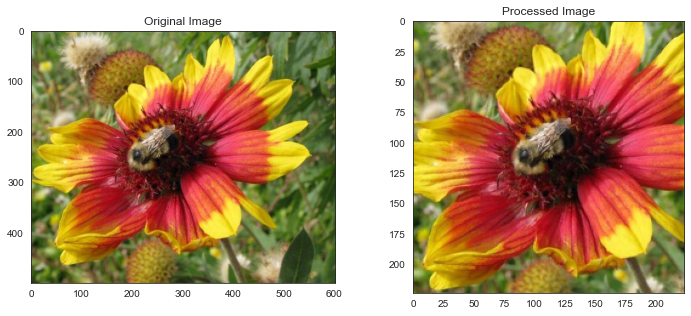

In [30]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Show the original image
image_pil = Image.open(image_path, "r")
ax1.imshow(np.array(image_pil))
ax1.set_title("Original Image")

# Show the processed image
sns.set_style("white")
image_path = "./Data/Proj_01/test/100/image_07896.jpg"
image_np   = process_image(image_path)
show_image_np(image_np, ax2, "Processed Image")

### Class Prediction

In [48]:
def predict(image_path, model, topk=5):
    '''Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Process an image
    image_np = process_image(image_path)
    
    # Transform "numpy" to "Pytorch tensor"
    image_tensor = torch.tensor(image_np)
    image_tensor = image_tensor.float()
    
    # Add a dimension for batch to avoid Runtime Error
    image_tensor = image_tensor.unsqueeze(0)
    
    # Move memory to device
    device       = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)
    
    # Run a model to predict
    model.eval()
    log_softmax = model(image_tensor)
    
    # Calculate Accuracy
    softmax = torch.exp(log_softmax) # Log(SoftMax) -> SoftMax
    
    # Get the class which have the largest probalibity
    # top_class size is the batch_size
    top_preds , top_classes = softmax.topk(topk, dim=1) 

    # Transform data type to list
    top_preds   = top_preds.cpu().detach().numpy().flatten()
    top_classes = top_classes.cpu().numpy().flatten()
    
    # get names
    top_names = []
    
    for i in range(topk):
        top_names.append(map_cat_to_name[str(top_classes[i]+1)])
    
    # Create a DataFrame
    df_pred = pd.DataFrame({"class":top_classes, "name": top_names, "probability": top_preds})
    df_pred = df_pred.set_index("class")
    
    return df_pred

In [49]:
image_path = "./Data/Proj_01/train/1/image_06734.jpg"
df_pred = predict(image_path, my_model, topk=5)
df_pred

,name,probability
class,,
0,pink primrose,0.998219
53,sunflower,0.001134
99,blanket flower,0.000259
13,spear thistle,0.000228
49,common dandelion,0.000047


### Create a function to show a prediction result image

In [75]:
def plot_solution(image_path, model, topk=5):
    # predict
    df_pred = predict(image_path, model, topk=topk)
    
    # get data 
    x_data = df_pred["name"].values
    y_data = df_pred["probability"].values
    
    # plot
    fig = plt.figure(figsize=(15,5))
    #
    ax1 = fig.add_subplot(1,2,1)
    image_np   = process_image(image_path)
    show_image_np(image_np, ax1, "Input Image")    
    #
    ax2 = fig.add_subplot(1,2,2)
    ax2.barh(x_data, y_data)
    ax2.set_title("Probability")
    ax2.grid()
    ax2.invert_yaxis()
    
    print(df_pred)
    

                   name  probability
class                               
0         pink primrose     0.998219
53            sunflower     0.001134
99       blanket flower     0.000259
13        spear thistle     0.000228
49     common dandelion     0.000047


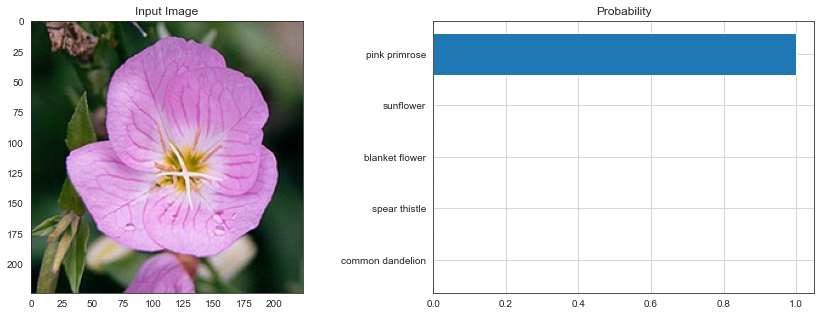

In [76]:
plot_solution(image_path, my_model, topk=5)